## Imports

In [826]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

## Parameters

### Inputs

In [827]:
edges_inputs_df = pd.read_csv("../inputs/edges_input.csv")
edges_inputs_label = edges_inputs_df['label'].values

In [828]:
radnet_inputs_df = pd.read_csv("../inputs/radnet_input.csv")
radnet_inputs_label = radnet_inputs_df['label'].values

### Outputs

In [829]:
fuzzy_output_df = pd.read_csv("../outputs/fuzzy_output.csv")
fuzzy_output_class = fuzzy_output_df['class'].values
fuzzy_output_confidence = fuzzy_output_df['confidence'].values

In [830]:
kalman_output_df = pd.read_csv("../outputs/kalman_output.csv")
kalman_output_class = kalman_output_df['class'].values
kalman_output_confidence = kalman_output_df['confidence'].values

## Confiança

### Confiança x Arestas

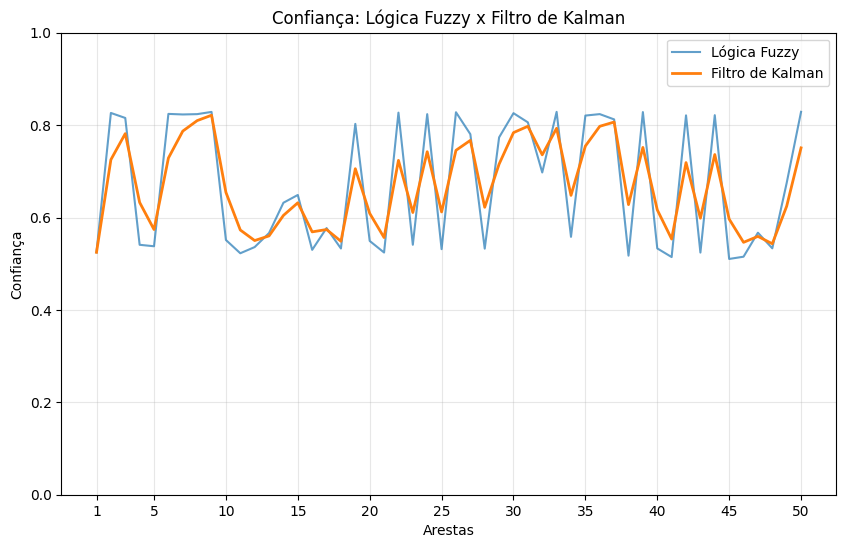

In [831]:
plt.figure(figsize=(10,6))

x_values = np.arange(1, len(fuzzy_output_confidence) + 1)

plt.plot(x_values, fuzzy_output_confidence, label="Lógica Fuzzy", alpha=0.7)
plt.plot(x_values, kalman_output_confidence, label="Filtro de Kalman", linewidth=2)

plt.title("Confiança: Lógica Fuzzy x Filtro de Kalman")
plt.xlabel("Arestas")
plt.ylabel("Confiança")

plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(0, 1)

n = len(fuzzy_output_confidence)
ticks = [1] + list(range(5, n + 1, 5))
plt.xticks(ticks)

os.makedirs("../results", exist_ok=True)
plt.savefig('../results/fuzzy_logic_kalman_filter.png', bbox_inches='tight')
plt.show()

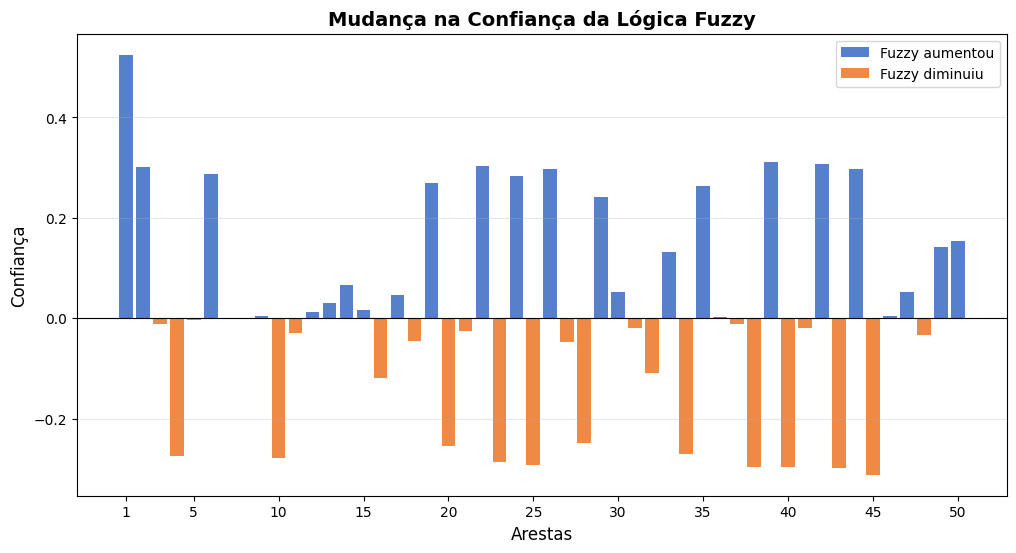

In [832]:
fuzzy_mudanca = np.diff(fuzzy_output_confidence, prepend=0)

plt.figure(figsize=(12, 6))

x_values = np.arange(1, len(fuzzy_mudanca) + 1)

fuzzy_pos = np.where(fuzzy_mudanca >= 0, fuzzy_mudanca, 0)
fuzzy_neg = np.where(fuzzy_mudanca < 0, fuzzy_mudanca, 0)

plt.bar(x_values, fuzzy_pos, color='#4472C4', label='Fuzzy aumentou', alpha=0.9)
plt.bar(x_values, fuzzy_neg, color='#ED7D31', label='Fuzzy diminuiu', alpha=0.9)

plt.title("Mudança na Confiança da Lógica Fuzzy", fontsize=14, fontweight='bold')
plt.xlabel("Arestas", fontsize=12)
plt.ylabel("Confiança", fontsize=12)

plt.legend(fontsize=10)
plt.grid(True, alpha=0.3, axis='y')
plt.axhline(y=0, color='black', linewidth=0.8)

n = len(fuzzy_mudanca)
ticks = [1] + list(range(5, n + 1, 5))
plt.xticks(ticks)

os.makedirs("../results", exist_ok=True)
plt.savefig('../results/fuzzy_confidence_change.png', bbox_inches='tight')
plt.show()

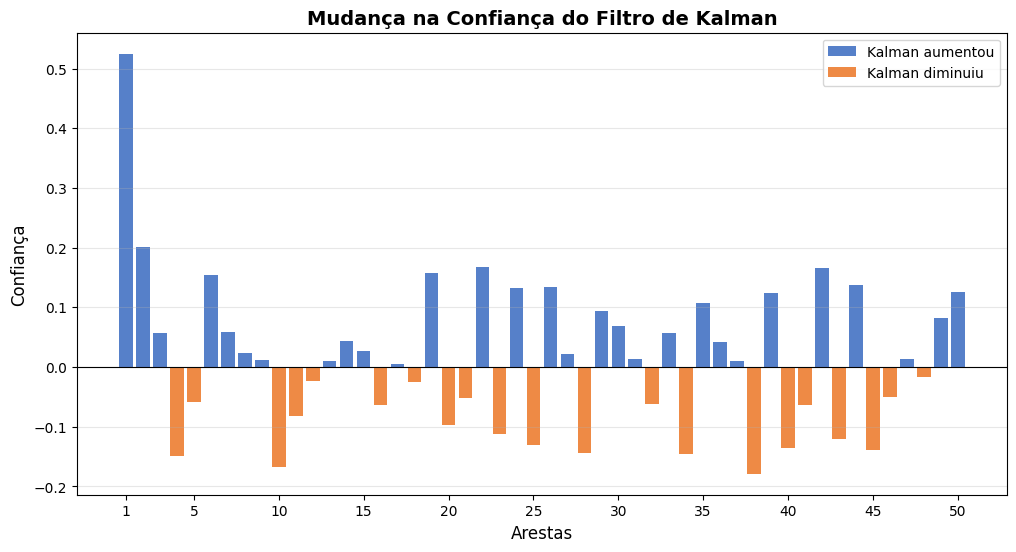

In [833]:
kalman_mudanca = np.diff(kalman_output_confidence, prepend=0)

plt.figure(figsize=(12, 6))

x_values = np.arange(1, len(kalman_mudanca) + 1)

kalman_pos = np.where(kalman_mudanca >= 0, kalman_mudanca, 0)
kalman_neg = np.where(kalman_mudanca < 0, kalman_mudanca, 0)

plt.bar(x_values, kalman_pos, color='#4472C4', label='Kalman aumentou', alpha=0.9)
plt.bar(x_values, kalman_neg, color='#ED7D31', label='Kalman diminuiu', alpha=0.9)

plt.title("Mudança na Confiança do Filtro de Kalman", fontsize=14, fontweight='bold')
plt.xlabel("Arestas", fontsize=12)
plt.ylabel("Confiança", fontsize=12)

plt.legend(fontsize=10)
plt.grid(True, alpha=0.3, axis='y')
plt.axhline(y=0, color='black', linewidth=0.8)

n = len(kalman_mudanca)
ticks = [1] + list(range(5, n + 1, 5))
plt.xticks(ticks)

plt.savefig('../results/kalman_confidence_change.png', bbox_inches='tight')
plt.show()